In [1]:
options(warn=-1)
options(readr.num_columns = 0)

library(MLmetrics)
library(tidyverse)
library(kableExtra)
library(ggplot2)
library(rpart)
library(rpart.plot)
library(caTools)

options(readr.num_columns = 0)
churn <- read_csv("../_build/data/churn_train.csv")

# Set the random seed
set.seed(972943)

# Define the work and holdout sets
split1 <- sample.split(churn$churn, SplitRatio = 0.8)

# Split the data into two data frames
work <- subset(churn, split1 == TRUE)
holdout <- subset(churn, split1 == FALSE)

# Set the random seed
set.seed(972943)

# Define the train and validate sets
split2 <- sample.split(work$churn, SplitRatio = 0.75)

# Split the data into two data frames
train <- subset(work, split2 == TRUE)
validate <- subset(work, split2 == FALSE)

modelDepth4CV <- rpart(churn ~ ., data = work, control = rpart.control(xval = 4, maxdepth = 4))
holdout$modelPred <- predict(modelDepth4CV, holdout, type = "class")


housingFull <- read_csv("../_build/data/housing_train.csv") %>% select(-Neighborhood, -Id) %>% mutate_if(is.character, factor)
# levels <- c("AllPub", "NoSeWa")
# housingFull$Utilities <- parse_factor(housingFull$Utilities, levels = levels)
# levels <- c("Norm", "Feedr", "PosN", "Artery", "RRAe", "RRNn", "RRAn", "PosA", "RRNe")
# housingFull$Condition2 <- parse_factor(housingFull$Condition2, levels = levels)
set.seed(972943)
split <- sample.split(housingFull, SplitRatio = 0.8)
housing <- subset(housingFull, split == TRUE)
housingHoldout <- subset(housingFull, split == FALSE)
housingModel <- rpart(SalePrice ~ ., data = housing)


Attaching package: 'MLmetrics'



The following object is masked from 'package:base':

    Recall



Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2


-- Attaching packages --------------------------------------- tidyverse 1.2.1 --


v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  


-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



Attaching package: 'kableExtra'



The following object is masked from 'package:dplyr':

    group_rows



# Performance Metrics

So far we have been evaluating our models via their accuracy, or the proportion of times when their predictions agreed with the true outcome. This is a simple measure to calculate, and in some circumstances is sufficient to evaluate the performance of a prediction model. However, there are many other performance metrics with different strengths and weaknesses that may be more useful depending on the context of the problem. In this section, we will cover some of the popular alternatives. The different metrics we describe in this chapter are organized by classification and regression problems.

## Classification

As a reminder, classification problems are those where the outcome variable is categorical. In this section, we focus on performance metrics for evaluating models with binary outcomes. 

### Confusion Matrices

From the accuracy score we calculated in Section [Holdout Sets](data_partition.html#holdout-sets), we know that our final model incorrectly predicted around 10% of the observations in the holdout set. But what kind of mistakes did it make? Did it label customers who *did* churn as non-churners? Or did it label customers who *did not* churn as churners? We can investigate this through a **confusion matrix**, or a table that breaks down the type of correct and incorrect predictions made by a model. We can create confusion matrices in R with the `ConfusionMatrix()` function from the `MLmetrics` package, which uses the following syntax:

```{admonition} Syntax
`MLmetrics::ConfusionMatrix(y_pred, y_true)`
+ *Required arguments*
  - `y_pred`: An atomic vector with the model predictions. 
  - `y_true`: An atomic vector with the true labels.
```

Applying this to our holdout set:

In [2]:
ConfusionMatrix(holdout$modelPred, holdout$churn)

      y_pred
y_true  no yes
   no  570  12
   yes  49  49

What does this table tell us? The diagonals of the table (*i.e.*, 570 and 49) represent the observations that the model predicted correctly (570 + 49 = 619). Conversely, the off-diagonals (12 and 49) represent the observations that the model predicted incorrectly (12 + 49 = 61). If we divide the number of correct predictions (619) by the total number of observations in the holdout set (680), we get our accuracy score of 91.0294%. 

Now let's focus on each value in the confusion matrix:

+ The top-left cell indicates that the model correctly identified *570* of the non-churners. 
+ The top-right cell indicates that the model incorrectly flagged *12* non-churners as churners.
+ The bottom-left cell indicates that the model incorrectly flagged *49* churners as non-churners.
+ The bottom-right cell indicates that the model correctly identified *49* of the churners.

Why might this be more informative than simple accuracy? Although accuracy tells us the total number of mistakes our model made, it does not tell us which *type* of mistakes the model made. In this context, there are two possible mistakes: flagging someone who is not going to churn as a churner (known as a **false positive**), and flagging someone who is going to churn as a non-churner (known as a **false negative**).

Depending on the business context, these two types of mistakes may not be associated with identical costs. Assume that if our model predicts a customer is about to churn, we plan to offer that customer a \$100 rebate to convince them to stay with the service. Assume also that losing a customer costs on average \$500 in lost revenue. In this case, it is costlier to lose a customer than it is to provide the rebate to a customer that would not have churned. If we make a false positive error and incorrectly assume that someone is about to churn, we will unnecessarily lose \$100, as the customer would have stayed regardless of whether we gave them the rebate. Conversely, if we make a false negative error and incorrectly assume that someone is not about to churn, we will not offer them a rebate and permanently lose them as a customer. Therefore, a false negative is costlier than a false positive in this context. 

This is another example of the role managers play in the data science pipeline. A thorough understanding of the business context is required to evaluate the relative costs of these two types of errors. A highly accurate model may still be insufficient if it makes highly costly mistakes. It is therefore important that managers and data scientists collaborate to evaluate models *in the context of the business problem*. 

Up until now, we have been implicitly applying a cutoff of 50% to our model's predictions. Remember that the decision tree algorithm predicts the *probability* that a given customer will churn (a value between 0% and 100%). When we applied the model to the holdout set using the `predict()` function (see Section [Holdout Sets](data_partition.html#holdout-sets)), we included the optional parameter `type = "class"`, which automatically converts the model's predictions from a continuous probability to a discrete prediction of `"yes"` / `"no"`. By default `predict()` uses a cutoff of 50%. This means that if our model predicts the probability of churning as greater than 50%, the final prediction is considered `"yes"`; if the probability is less than 50%, the final prediction is considered `"no"`. 

This cutoff of 50% seems like a natural threshold, as it means we only predict `"yes"` if the model predicts it is more likely than not that the customer will churn. However, there is no reason we *must* choose 50%. As we noted above, the cost of a false positive and false negative error may be different. If the cost of a false positive is very high, we may only want to predict "churn" if we are very, very confident that the customer is about to churn. Therefore, we may want to increase the threshold above 50%. For example, we may only want to predict "churn" if the model's predicted probability is greater than 85%. Conversely, if the cost of a false negative is very high, we may want to decrease the threshold below 50%.

If we apply a different cutoff to our predictions, we will get a different confusion matrix for the same model. Let's start with a cutoff of 85%. First, we need to re-run the `predict()` function so that we get the raw probabilities, instead of just `"yes"` / `"no"`. We can do this by simply excluding `type = "class"` in our call to the `predict()` function:

In [3]:
modelProbsMatrix <- predict(modelDepth4CV, holdout)
head(modelProbsMatrix)

no        yes       
1 0.9520000 0.04800000
2 0.9520000 0.04800000
3 0.9520000 0.04800000
4 0.1052632 0.89473684
5 0.9142857 0.08571429
6 0.9520000 0.04800000

This creates a matrix, where one column represents the model's predicted probability that the observation is a `"yes"`, and the other represents the predicted probability that the observation is a `"no"`. Note that these two columns always sum to one. We are only interested in the model's predicted probability that an observation will churn, so we only care about the `yes` column here. Therefore, we will store the second column in a vector called `modelProbs`:

In [4]:
modelProbs <- modelProbsMatrix[,2]
head(modelProbs)

1          2          3          4          5          6 
0.04800000 0.04800000 0.04800000 0.89473684 0.08571429 0.04800000

This means that according to the model, the first three observations in the holdout set have a 4.8% chance of churning, the fourth observation has an 8.9% chance, etc.

Now that we have the raw probabilities, we can apply our custom cutoff of 0.85. In the code below, we create a new column in `holdout` called `modelPred0.85`, where each row equals `"yes"` if the predicted probability of churning is greater than 85%, and `"no"` if the predicted probability is less than 85%.

In [5]:
holdout$modelPred0.85 <- ifelse(modelProbs > 0.85, "yes", "no")

Now we can use `ConfusionMatrix()` to calculate the confusion matrix with our new cutoff of 85%:

In [6]:
ConfusionMatrix(holdout$modelPred0.85, holdout$churn)

      y_pred
y_true  no yes
   no  579   3
   yes  76  22

As expected, this confusion matrix looks different than the one where we used a cutoff of 50%. Now, the model makes only three false positive errors, but it makes many more false negative errors (76).

Let's repeat this process with a lower cutoff of 15%.

In [7]:
holdout$modelPred0.15 <- ifelse(modelProbs > 0.15, "yes", "no")
ConfusionMatrix(holdout$modelPred0.15, holdout$churn)

      y_pred
y_true  no yes
   no  524  58
   yes  33  65

Now that we apply a lower cutoff, the model makes fewer false negative errors (33), but more false positive errors (58).

As emphasized previously, it is the manager's job to determine which one of these cutoffs is appropriate. In general, if based on the business context a false negative error is costlier, one would want to apply a lower cutoff. If instead a false positive error is costlier, one would want to apply a higher cutoff.

### ROC Curves

To evaluate our model on the holdout set, we could continue looking at confusion matrices associated with different cutoffs. However, there are an infinite number of possible cutoffs to pick from between 0 and 1. Therefore, we need an evaluation method that is independent of arbitrary cutoff choices. One such method is the **ROC curve** (Receiver Operating Characteristic Curve), which plots the model's false positive and true positive rates across all possible cutoff values. 

Recall our three confusion matrices, which show the model's performance at different cutoffs (0.15, 0.5, and 0.85). For 0.15, the false positive rate (or the proportion of non-churners that are incorrectly flagged as churners) is 58 / (524 + 58) = 9.97%. The true positive rate (or the proportion of churners that are correctly flagged as churners) is 65 / (33 + 65) = 66.33%. For 0.5 the false positive and true positive rates are (2.06%, 50%) respectively, and for 0.85 these values are (0.52%, 22.45%). 

We also know that if we used a cutoff of one, all of the predictions would be "not churn", so the false positive and true positive rates would be (0%, 0%). Similarly, if we used a cutoff of zero, all of the predictions would be "churn", so the false positive and true positive rates would be (100%, 100%).

Let's plot these five points, with the false positive rate on the x-axis and the true positive rate on the y-axis:

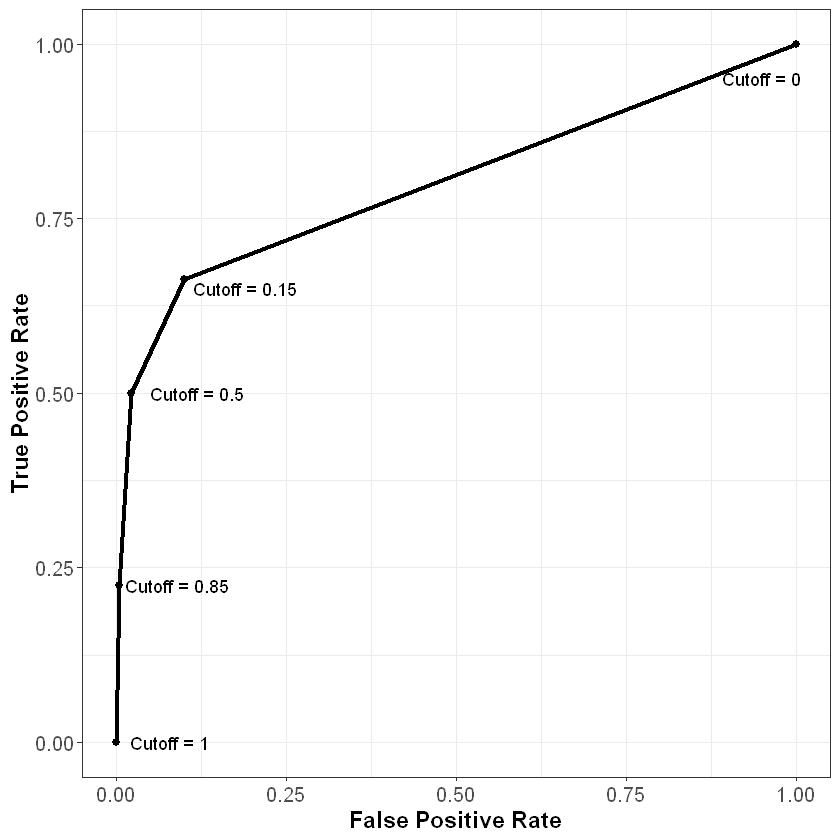

In [8]:
points <- data.frame(fp=c(0, 0.0997, 0.02306, 0.0052, 1), tp=c(0, 0.6633, 0.5, 0.2245, 1))
ggplot(points, aes(x=fp, y=tp)) + geom_point(size=2)  + geom_line(size=1.25) +
  theme_bw() +
  xlim(0, 1) + ylim(0, 1) +
  xlab("False Positive Rate") + ylab("True Positive Rate") + 
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold")) + 
  annotate("text", x = 0.08, y = 0, label = "Cutoff = 1") + 
  annotate("text", x = 0.09, y = 0.2245, label = "Cutoff = 0.85") +
  annotate("text", x = 0.12, y = 0.5, label = "Cutoff = 0.5") +
  annotate("text", x = 0.19, y = 0.65, label = "Cutoff = 0.15") +
  annotate("text", x = 0.95, y = 0.95, label = "Cutoff = 0")

As we can see from this curve, we face a trade-off when it comes to the cutoff value we choose. As we decrease the value of the cutoff, our true positive rate increases, which means we correctly flag more people who will end up churning. However, our false positive rate also increases, meaning we incorrectly flag more people who will *not* end up churning. As always, how one chooses to balance this trade-off (*i.e.*, how to pick the correct cutoff) depends on the business context of the problem.

To understand this curve even further, consider what it would look like if we just randomly guessed the probability of churning for each observation. Because we are guessing randomly, at any given cutoff the probability of a false positive would be the same as the probability of a true positive. Therefore, a very poor model that randomly guessed at the outcome would be plotted on the 45-degree line, where the false positive and true positive rates are the same. This is shown below in the red dotted line.

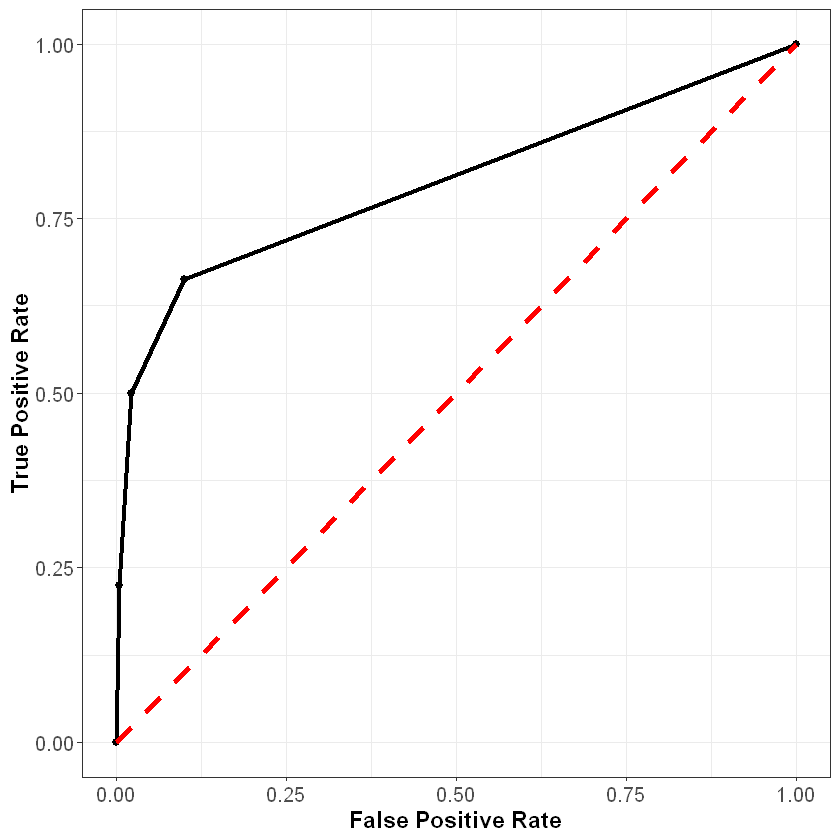

In [9]:
points <- data.frame(fp=c(0, 0.0997, 0.02306, 0.0052, 1), tp=c(0, 0.6633, 0.5, 0.2245, 1))
badPoints <- data.frame(fp=c(0,1), tp=c(0,1))
ggplot(points, aes(x=fp, y=tp)) + geom_point(size=2)  + geom_line(size=1.25) +
  theme_bw() +
  xlim(0, 1) + ylim(0, 1) +
  xlab("False Positive Rate") + ylab("True Positive Rate") + 
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold")) + 
  geom_line(data=badPoints, aes(x=fp, y=tp), linetype = "dashed", color="red", size=1.5) 

Finally, consider what the curve would look like with a perfect model. For observations that did churn, this model would predict the probability of churning to be 100%, and for observations that did not churn, this model would predict the probability of churning to be 0%. At a threshold of one, the false positive and true positive rates would still be (0%, 0%), and at a threshold of zero, these rates would still be (100%, 100%). However, for any other threshold, the false positive and true positive rates would be (0%, 100%). This curve is plotted below in the blue dashed line.

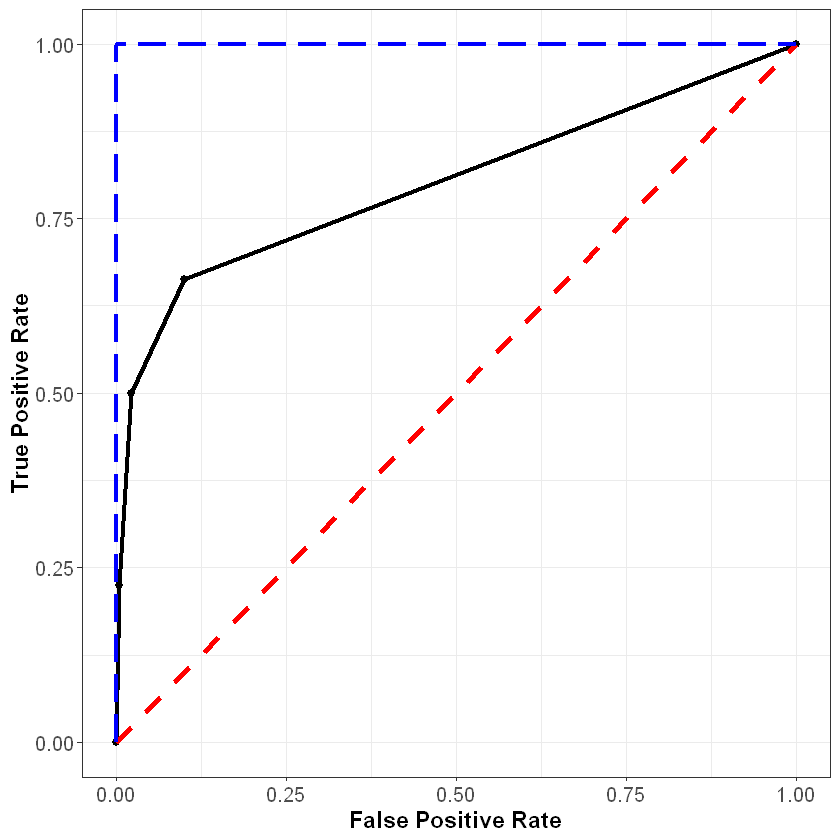

In [10]:
points <- data.frame(fp=c(0, 0.0997, 0.02306, 0.0052, 1), tp=c(0, 0.6633, 0.5, 0.2245, 1))
badPoints <- data.frame(fp=c(0,1), tp=c(0,1))
perfectPoints <- data.frame(fp=c(0,0,1), tp=c(0,1,1))
ggplot(points, aes(x=fp, y=tp)) + geom_point(size=2)  + geom_line(, size=1.25) +
  theme_bw() +
  xlim(0, 1) + ylim(0, 1) +
  xlab("False Positive Rate") + ylab("True Positive Rate") + 
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold")) + 
  geom_line(data=badPoints, aes(x=fp, y=tp), linetype = "dashed", color="red", size=1.5) +
  geom_line(data=perfectPoints, aes(x=fp, y=tp), linetype = "longdash", color="blue", size=1.25)

In general, the better our model, the closer the ROC curve will be to the blue line, and the further away it will be from the red line. 

Access the web application below to further explore the relationship between confusion matrices, ROC curves, and the model threshold.

<a href="https://hbs-data-science.shinyapps.io/churn_roc/" class="btn btn-primary" style="color:white;" target="_blank">Launch Application!</a>

We can plot the ROC curve for our model in R using the `prediction()` and `performance()` functions from the `ROCR` package. These functions use the following syntax:

```{admonition} Syntax
`ROCR::prediction(y_pred, y_true)`
+ *Required arguments*
  - `y_pred`: An atomic vector with the model predictions. 
  - `y_true`: An atomic vector with the true labels.
```

```{admonition} Syntax
`ROCR::performance(predictionObj, measure1, measure2, ...)`
+ *Required arguments*
  - `predictionObj`: An object created using the `prediction()` function. 
  - `measure1`: The desired model performance measure. See the "Details" section [here](https://www.rdocumentation.org/packages/ROCR/versions/1.0-1/topics/performance) for a full list. For our purposes, we will use "tpr" for the true positive rate and "fpr" for the false positive rate.
+ *Optional arguments*
  - `measure2, ...`: Any additional model performance measures. 
```
  
Below we apply these functions to create an object `roc`, which can be passed to the `plot()` function to plot the ROC curve:

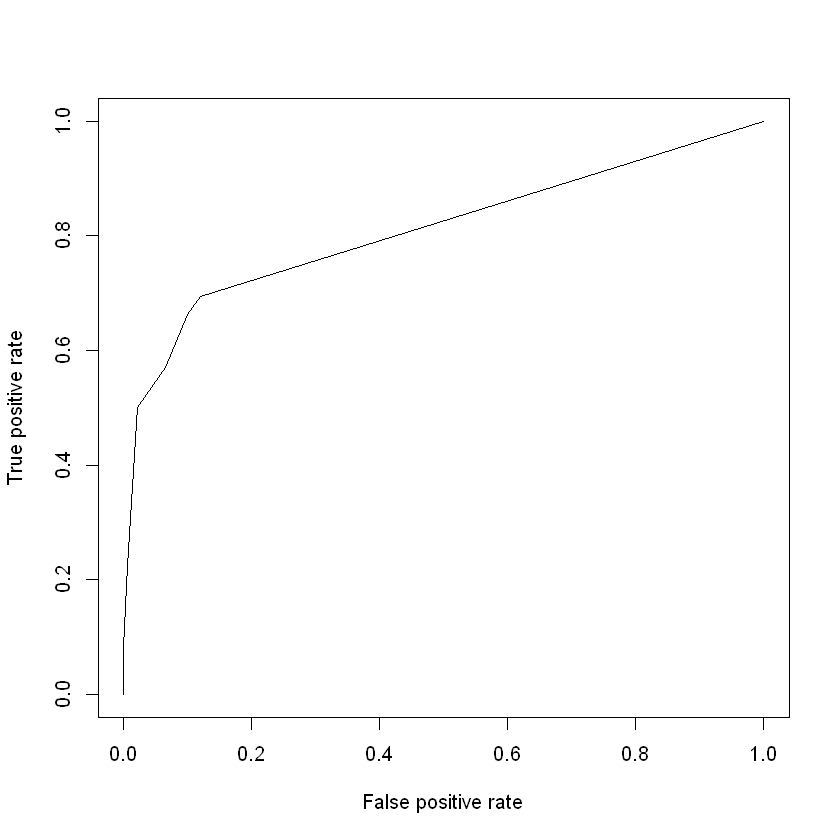

In [11]:
library(ROCR)

rocPrediction <- prediction(modelProbs, holdout$churn)
roc <- performance(rocPrediction, "tpr", "fpr")

plot(roc)

We can summarize this plot numerically through a measure known as **area under the ROC curve (AUC)**, which (as the name implies) measures the area underneath our plotted ROC curve. If our curve fell on the red dotted line (representing the worst possible model), the area under the curve would be 0.5. Conversely, if our curve fell on the blue dotted line (representing the best possible model), the area under the curve would be 1. Therefore, the closer our AUC is to 1, the better our model, and the closer it is to 0.5, the worse our model. Note that because it is based on the ROC curve, this metric is independent of any particular cutoff value, unlike accuracy and confusion matrices. 

We can calculate the AUC of our model in R using the `AUC()` function from the `MLmetrics` package, which uses the following syntax:

```{admonition} Syntax
`MLmetrics::AUC(y_pred, y_true)`
+ *Required arguments*
  - `y_pred`: An atomic vector with the model's predicted probabilities. 
  - `y_true`: An atomic vector with the true labels, represented numerically as 0 / 1. Note that this is different from some of the other functions from `MLmetrics`, where the labels can be in their original form (*i.e.*, "churn" / "not churn"). 
```

Below we apply this function to our model. Note that `holdout$churn` labels the observations as "no" or "yes", but the `AUC()` function expects them to be labeled as `0` or `1` (respectively). Therefore, we first need to re-code the true values from "no" / "yes" to 0 / 1.

In [12]:
# Convert labels to binary (0 / 1)
trueLabelsBinary <- ifelse(holdout$churn=="yes", 1, 0)

# Calculate AUC
AUC(modelProbs, trueLabelsBinary)

[1] 0.8106021

### Log Loss

Another problem with simple accuracy is that it does not account for the strength of each prediction. Imagine two competing models that both correctly predict a given customer will churn. Model 1 outputs a predicted probability of 0.51, while Model 2 outputs a predicted probability of 0.99. If we were scoring based on simple accuracy, these models would be considered equivalent (at a cutoff of 0.5) - both correctly predicted that the customer would churn. The problem with this scoring method is that it does not reward Model 2 for having a predicted probability much closer to 1.

One solution to this issue is to score classification models via **log loss**. See the section [Log Loss](../07_logistic_regression/build_log_model.html#log-loss) from a previous chapter for a description of the log loss metric.

In [13]:
LogLoss(modelProbs, trueLabelsBinary)

[1] 0.2798582

## (&sect;) Regression

:::{note}
This section is optional, and will not be covered in the DSM course.
:::

As a reminder, regression problems are those where the outcome variable is continuous. In this section, we focus on performance metrics for evaluating models with continuous outcomes. To illustrate these metrics we will return to the regression tree model we fit in the section [Regression Trees](../09_dt_rf/decision_trees.html#regression-trees), where our outcome variable was the sales price of residential homes (`SalePrice`).

### RMSE

One of the most common performance metrics for continuous outcomes is **root mean square error (RMSE)**, which is defined as follows:

$$ RMSE = \sqrt{\frac{\sum_{i=1}^n{(y_i - \hat{y_i})^2}}{n}} $$

where 

+ $n$ is the number of observations in the data set;
+ $y_i$ is the observed realization of observation $i$; and
+ $\hat{y_i}$ is the model's prediction for observation $i$.

To understand this formula intuitively, let us examine each of its components. The term $y_i - \hat{y_i}$ represents the model's error for observation $i$, or the difference between the true value and the model's predicted value. We square this difference so that positive and negative errors do not cancel each other out. We then sum these squared errors for all observations in our data set, represented by the term $\sum_{i=1}^n{(y_i - \hat{y_i})^2}$. Next we divide that sum by the total number of observations in the data set ($n$) to get the **m**ean (average) of the **s**quared **e**rrors (hence the "MSE" in "RMSE"). Finally, we take the square root of that term because the MSE is in squared units. 

Like the other performance metrics we have seen, the `MLmetrics` package has a function we can use to calculate RMSE:

```{admonition} Syntax
`MLmetrics::RMSE(y_pred, y_true)`
+ *Required arguments*
  - `y_pred`: An atomic vector with the model's predicted values. 
  - `y_true`: An atomic vector with the true values. 
```

First, we apply the `housingModel` we fit in [Regression Trees](../09_dt_rf/decision_trees.html#regression-trees) to our holdout set:

In [14]:
housingHoldout$modelPred <- predict(housingModel, housingHoldout)
head(housingHoldout)

MSSubClass MSZoning LotFrontage LotArea Street Alley LotShape LandContour
1 60         RL        68         11250   Pave   NA    IR1      Lvl        
2 20         RL        75         10084   Pave   NA    Reg      Lvl        
3 60         RL        NA         10382   Pave   NA    IR1      Lvl        
4 45         RM        57          7449   Pave   Grvl  Reg      Bnk        
5 20         RL        75          9742   Pave   NA    Reg      Lvl        
6 20         RL       110         14230   Pave   NA    Reg      Lvl        
  Utilities LotConfig ... PoolQC Fence MiscFeature MiscVal MoSold YrSold
1 AllPub    Inside    ... NA     NA    NA            0      9     2008  
2 AllPub    Inside    ... NA     NA    NA            0      8     2007  
3 AllPub    Corner    ... NA     NA    Shed        350     11     2009  
4 AllPub    Inside    ... NA     GdPrv NA            0      6     2007  
5 AllPub    Inside    ... NA     NA    NA            0      9     2008  
6 AllPub    Corner    ... NA     NA    NA            0      7     2009  
  SaleType SaleCondition SalePrice modelPred
1 WD       Normal        223500    191405.2 
2 WD       Normal        307000    247370.5 
3 WD       Normal        200000    240885.3 
4 WD       Normal        139400    191405.2 
5 WD       Normal        230000    247370.5 
6 WD       Normal        256300    247370.5

Now we can apply the `RMSE` function to calculate the root mean squared error of our model on the holdout set:

In [15]:
RMSE(housingHoldout$modelPred, housingHoldout$SalePrice)

[1] 43559.32

This provides an estimate of the typical difference between our model's predictions and the true value of `SalePrice`.

### MAE

Due to the fact that the error terms in RMSE are squared, the RMSE metric can be particularly sensitive to outliers. If you are working with a data set with a significant number of outliers, RMSE may exaggerate the difference between your model's predictions and the true values. In this scenario, a common alternative is the **mean absolute error (MAE)**, which is calculated as follows:

$$ MAE = \frac{1}{n}\sum_{i=1}^{n} | y_i - \hat{y_i} | $$

where 

+ $n$ is the number of observations in the data set;
+ $y_i$ is the observed realization of observation $i$; and
+ $\hat{y_i}$ is the model's prediction for observation $i$.

Intuitively, MAE is the average of the absolute difference between our model's predictions and the true values. In the formula for RMSE, we square the errors to prevent the negative and positive errors from canceling each other out. Alternatively, the MAE metric addresses this problem by taking the absolute value of the errors ($| y_i - \hat{y_i} |$). Because the errors are not squared, the MAE metric is less sensitive to outliers than RMSE. 

The `MLmetrics` package has a function we can use to calculate MAE:

```{admonition} Syntax
`MLmetrics::MAE(y_pred, y_true)`
+ *Required arguments*
  - `y_pred`: An atomic vector with the model's predicted values. 
  - `y_true`: An atomic vector with the true values. 
```

Below we apply this function to calculate the MAE of our model on the holdout set:

In [16]:
MAE(housingHoldout$modelPred, housingHoldout$SalePrice)

[1] 30858.64

It is important to note that because the two metrics are calculated differently, one should *not* compare the RMSE and MAE values directly.